In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq
from scipy.signal import windows
from scipy.fft import fftshift

In [2]:
def load_radar_file(filepath, num_frames, num_chirp, samples_per_chirp, num_rx):
    """
    Load raw radar files for processing (Note: this function is only needed when processing raw radar data into an image)

    Returns: 
        Loaded complex-valued radar (adc) files for the specified radar type
    """
    fid = open(f'{filepath}', 'rb')

    adcData = np.fromfile(fid, dtype='<i2')
    adcData = np.reshape(adcData, (int(adcData.shape[0] / (num_rx * 2)), num_rx * 2))
    adcData = adcData[:, [0, 1, 2, 3]] + 1j * adcData[:, [4, 5, 6, 7]]

    adcData = adcData.reshape(num_frames, num_chirp, samples_per_chirp, num_rx)

    return adcData

In [ ]:
# TODO dont know if we should use DC offset for each RX separately or for all RX together??
# def remove_dc_offset(adc_data):
#     """
#     Remove DC offset from the radar data.

#     Args:
#         adc_data (numpy.ndarray): The raw radar data with shape (num_frames, num_chirp, samples_per_chirp, num_rx).

#     Returns:
#         numpy.ndarray: DC-offset removed data.
#     """
#     return adc_data - np.mean(adc_data, axis=2, keepdims=True)  # Remove DC offset along samples_per_chirp dimension


def average_chirps(adc_data):
    """
    Average the chirps in the radar data.

    Args:
        adc_data (numpy.ndarray): The raw radar data with shape (num_frames, num_chirp, samples_per_chirp, num_rx).

    Returns:
        numpy.ndarray: Averaged chirps with shape (num_frames, samples_per_chirp, num_rx).
    """
    return np.mean(adc_data, axis=1)  # Average across chirps dimension

def average_frames(avg_chirps):
    """
    Average the frames in the radar data.

    Args:
        avg_chirps (numpy.ndarray): The averaged chirps with shape (num_frames, samples_per_chirp, num_rx).

    Returns:
        numpy.ndarray: Averaged frames with shape (samples_per_chirp, num_rx).
    """
    return np.mean(avg_chirps, axis=0)  # Average across frames dimension

def average_rx(avg_frames):
    """
    Average the RX channels in the radar data.

    Args:
        avg_frames (numpy.ndarray): The averaged frames with shape (samples_per_chirp, num_rx).

    Returns:
        numpy.ndarray: Averaged RX channels with shape (samples_per_chirp,).
    """
    return np.mean(avg_frames, axis=1)  # Average across RX channels dimension

In [3]:
c = 3e8                         # speed of light in m/s

# frame config
# NUM_FRAMES = 8
# NUM_CHIRP = 128                 # chirp loop count
# PERIODICITY = 40                # periodicity in ms
NUM_FRAMES = 100*2
NUM_CHIRP = 128                 # chirp loop count
PERIODICITY = 100               # periodicity in ms

# profile config
FREQUENCY = 77                  # start frequency
SAMPLES_PER_CHIRP = 256         # ADC number of samples
SAMPLE_RATE_KHZ = 10000         # digout sample rate in kHz
RAMP_END_TIME_US = 60           # us
ADC_START_TIME_US = 6           # us
FREQ_SLOPE_MHZ = 29.982         # frequency slope in MHz (/us)

# chan & adc config
NUMRX = 4

SAMPLE_RATE = SAMPLE_RATE_KHZ * 1e3             # digout sample rate in Hz
SWEEP_TIME = SAMPLES_PER_CHIRP / SAMPLE_RATE
FREQ_SLOPE = FREQ_SLOPE_MHZ * 1e12              # frequency slope in Hz (/s)

BANDWIDTH = FREQ_SLOPE * SWEEP_TIME             # bandwidth in Hz
RESOLUTION = c / (2 * BANDWIDTH)                # range resolution in m

print(f"Start frequency: {FREQUENCY} Hz")
print(f"Bandwidth: {BANDWIDTH} Hz")
print(f"Sweep time: {SWEEP_TIME} s")
print(f"Slope: {FREQ_SLOPE} Hz/s")
print(f"Range resolution: {RESOLUTION} m")
print(f"Sample rate: {SAMPLE_RATE} Hz")

Start frequency: 77 Hz
Bandwidth: 767539200.0 Hz
Sweep time: 2.56e-05 s
Slope: 29982000000000.0 Hz/s
Range resolution: 0.19542975785471284 m
Sample rate: 10000000.0 Hz


In [4]:
adc_data0 = load_radar_file('./adc_data_boxes_empty.bin', NUM_FRAMES, NUM_CHIRP, SAMPLES_PER_CHIRP, NUMRX)
print("ADC Data 0 shape:", adc_data0.shape)

adc_data1 = load_radar_file('./adc_data_boxes_full.bin', NUM_FRAMES, NUM_CHIRP, SAMPLES_PER_CHIRP, NUMRX)
print("ADC Data 1 shape:", adc_data1.shape)

ADC Data 0 shape: (200, 128, 256, 4)
ADC Data 1 shape: (200, 128, 256, 4)


Processing ADC data with shape: (200, 128, 256, 4)
Averaged data shape: (256,)
Processing ADC data with shape: (200, 128, 256, 4)
Averaged data shape: (256,)


(0.0, 2.0)

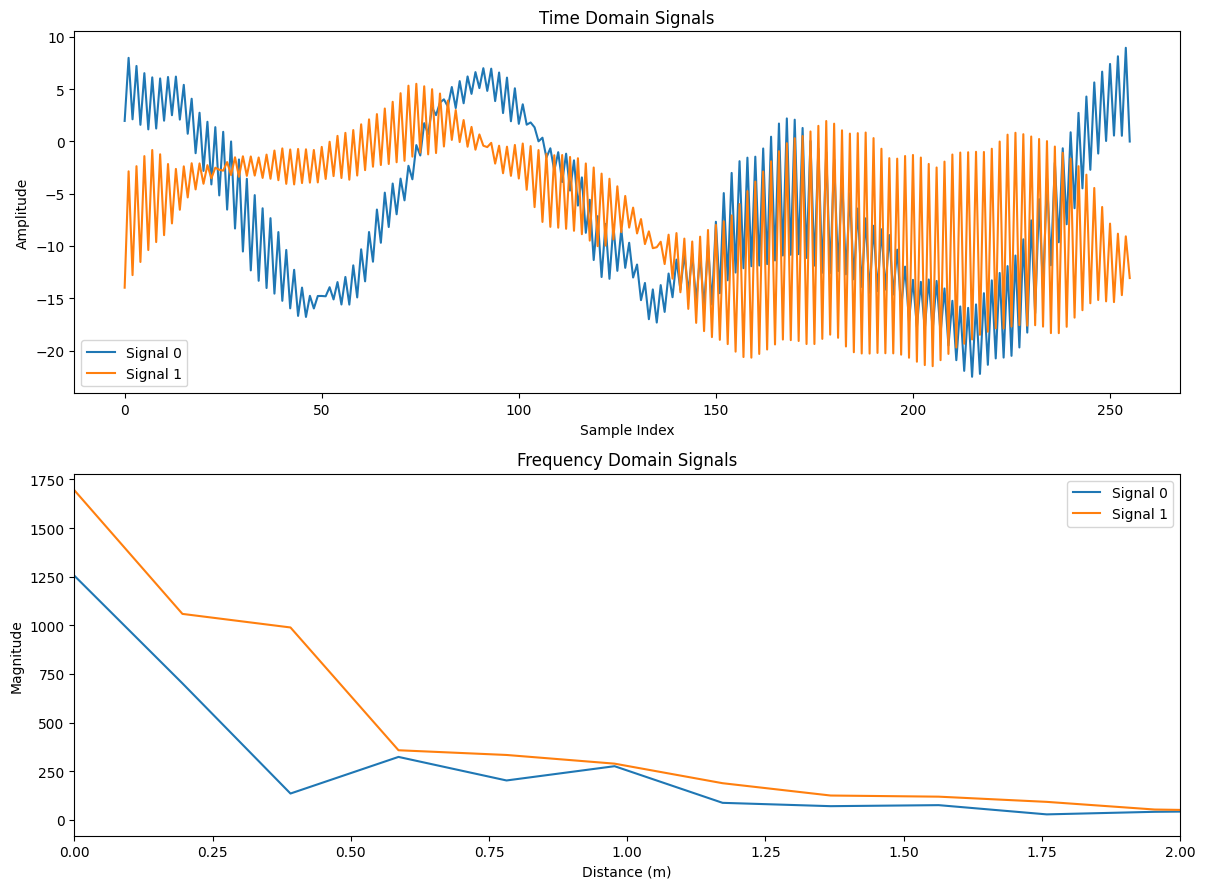

In [9]:
signals_t = []
signals_f = []

for adc_data in [adc_data0, adc_data1]:
    print("Processing ADC data with shape:", adc_data.shape)    # shape: (num_frames, num_chirp, samples_per_chirp, num_rx)

    # Average across chirps dimension
    avg_chirps = np.mean(adc_data, axis=1)                      # shape: (num_frames, samples_per_chirp, num_rx)
    avg_frames = np.mean(avg_chirps, axis=0)                    # shape: (samples_per_chirp, num_rx)
    avg_rx = np.mean(avg_frames, axis=1)                        # shape: (samples_per_chirp,)

    data = avg_rx
    print("Averaged data shape:", data.shape)                # shape: (samples_per_chirp,)

    # Calculate FFT
    fft_result = fft(data)

    signals_t.append(data)
    signals_f.append(fft_result)

# Plot the signals for all signals
fft_freqs = fftfreq(SAMPLES_PER_CHIRP, 1/SAMPLE_RATE)
fft_meters = fft_freqs * c / (2 * FREQ_SLOPE)
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
for i, signal in enumerate(signals_t):
    plt.plot(signal, label=f'Signal {i}')
plt.title('Time Domain Signals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.subplot(2, 1, 2)
for i, fft_result in enumerate(signals_f):
    plt.plot(fft_meters[:SAMPLES_PER_CHIRP // 2], np.abs(fftshift(fft_result))[:SAMPLES_PER_CHIRP // 2], label=f'Signal {i}')
plt.title('Frequency Domain Signals')
plt.xlabel('Distance (m)')
plt.ylabel('Magnitude')
plt.legend()
plt.tight_layout()

plt.xlim(0, 2)  # Limit x-axis to 2 meters

In [10]:
adc_data = adc_data1

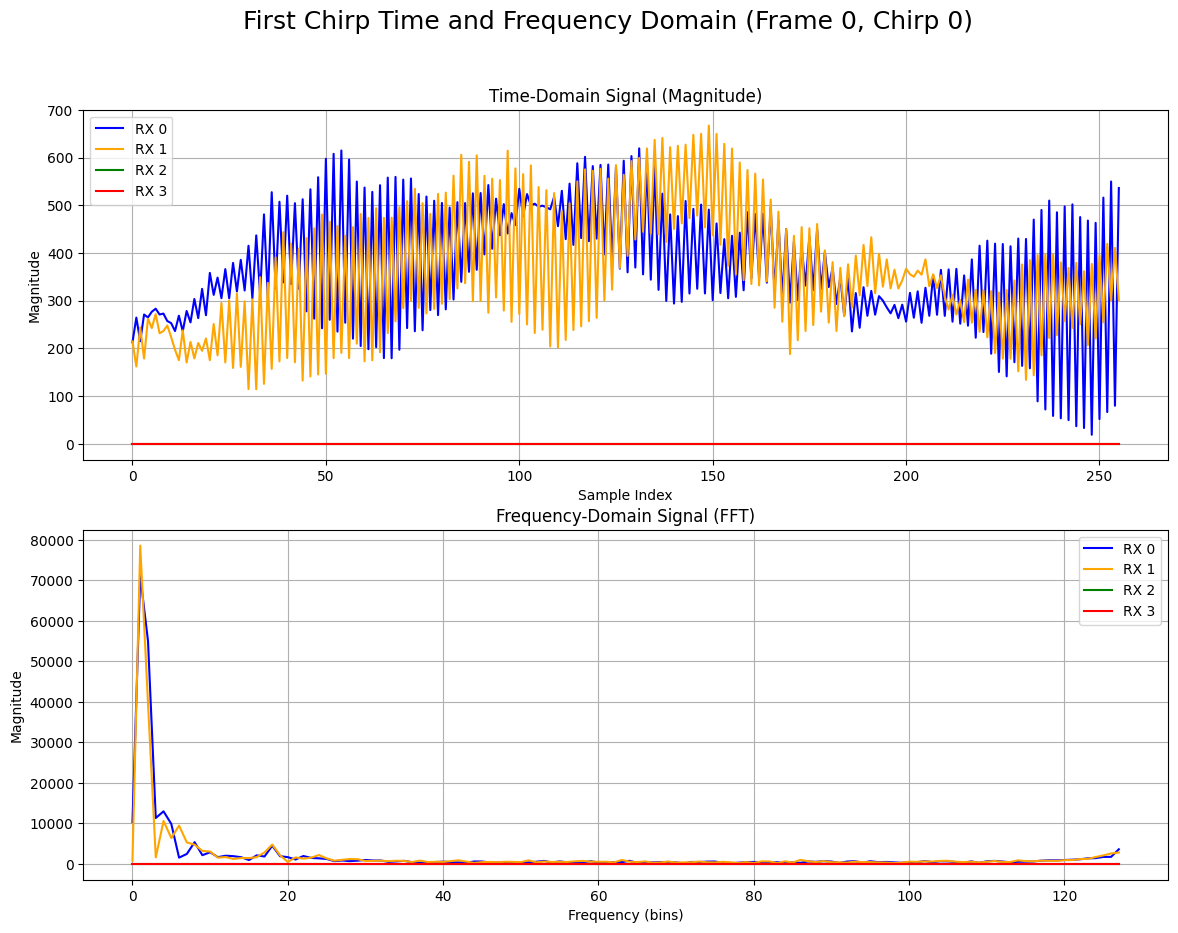

In [11]:
frame_idx = 0
chirp_idx = 0

# FFT on the first chirps across all RXs
first_chirp_ffts = np.array([fft(adc_data[frame_idx, chirp_idx, :, rx]) for rx in range(NUMRX)])
N = first_chirp_ffts.shape[1]

fig, axs = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('First Chirp Time and Frequency Domain (Frame 0, Chirp 0)', fontsize=18)

# Subplot 1: Time-domain magnitude
axs[0].plot(np.abs(adc_data[chirp_idx, frame_idx, :, 0]), label='RX 0', color='blue')
axs[0].plot(np.abs(adc_data[chirp_idx, frame_idx, :, 1]), label='RX 1', color='orange')
axs[0].plot(np.abs(adc_data[chirp_idx, frame_idx, :, 2]), label='RX 2', color='green')
axs[0].plot(np.abs(adc_data[chirp_idx, frame_idx, :, 3]), label='RX 3', color='red')
axs[0].set_title('Time-Domain Signal (Magnitude)')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Magnitude')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Frequency-domain magnitude (FFT of RX 0)
axs[1].plot(np.abs(first_chirp_ffts[0, :N//2]), label='RX 0', color='blue')
axs[1].plot(np.abs(first_chirp_ffts[1, :N//2]), label='RX 1', color='orange')
axs[1].plot(np.abs(first_chirp_ffts[2, :N//2]), label='RX 2', color='green')
axs[1].plot(np.abs(first_chirp_ffts[3, :N//2]), label='RX 3', color='red')
axs[1].set_title('Frequency-Domain Signal (FFT)')
axs[1].set_xlabel('Frequency (bins)')
axs[1].set_ylabel('Magnitude')
axs[1].legend()
axs[1].grid(True)

In [50]:
# coherently average the chirps for each frame
chirps_avg = np.mean(adc_data, axis=1)                    # Average across chirps
print("Chirps Average shape:", chirps_avg.shape)

Chirps Average shape: (200, 256, 4)


In [51]:
# remove DC from all data
chirps_no_dc = chirps_avg - np.mean(chirps_avg, axis=1, keepdims=True)
print("Chirps No DC shape:", chirps_no_dc.shape)

Chirps No DC shape: (200, 256, 4)


In [52]:
# frame-to-frame background subtraction
chirps_subtracted = np.copy(chirps_no_dc)  # Create a copy for subtraction
for i in range(1, NUM_FRAMES):
    chirps_subtracted[i] -= chirps_no_dc[i - 1]  # Subtract the previous frame

# remove first frame
chirps_subtracted = chirps_subtracted[1:]  # Remove the first frame
print("Chirps Subtracted shape:", chirps_subtracted.shape)

Chirps Subtracted shape: (199, 256, 4)


In [53]:
# chirps = chirps_subtracted  # Update chirps to the subtracted data
chirps = chirps_no_dc  # Update chirps to the subtracted data

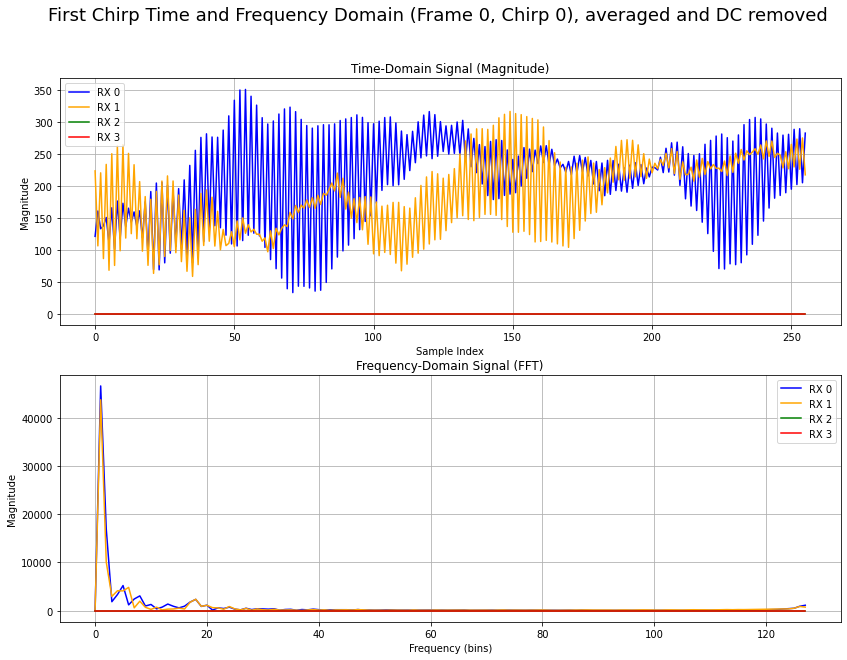

In [54]:
frame_idx = 0

# FFT on the first chirps across all RXs
first_chirp_ffts = np.array([fft(chirps[frame_idx, :, rx]) for rx in range(NUMRX)])
N = first_chirp_ffts.shape[1]

fig, axs = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('First Chirp Time and Frequency Domain (Frame 0, Chirp 0), averaged and DC removed', fontsize=18)

# Subplot 1: Time-domain magnitude
axs[0].plot(np.abs(chirps[frame_idx, :, 0]), label='RX 0', color='blue')
axs[0].plot(np.abs(chirps[frame_idx, :, 1]), label='RX 1', color='orange')
axs[0].plot(np.abs(chirps[frame_idx, :, 2]), label='RX 2', color='green')
axs[0].plot(np.abs(chirps[frame_idx, :, 3]), label='RX 3', color='red')
axs[0].set_title('Time-Domain Signal (Magnitude)')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Magnitude')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Frequency-domain magnitude (FFT of RX 0)
axs[1].plot(np.abs(first_chirp_ffts[0, :N//2]), label='RX 0', color='blue')
axs[1].plot(np.abs(first_chirp_ffts[1, :N//2]), label='RX 1', color='orange')
axs[1].plot(np.abs(first_chirp_ffts[2, :N//2]), label='RX 2', color='green')
axs[1].plot(np.abs(first_chirp_ffts[3, :N//2]), label='RX 3', color='red')
axs[1].set_title('Frequency-Domain Signal (FFT)')
axs[1].set_xlabel('Frequency (bins)')
axs[1].set_ylabel('Magnitude')
axs[1].legend()
axs[1].grid(True)

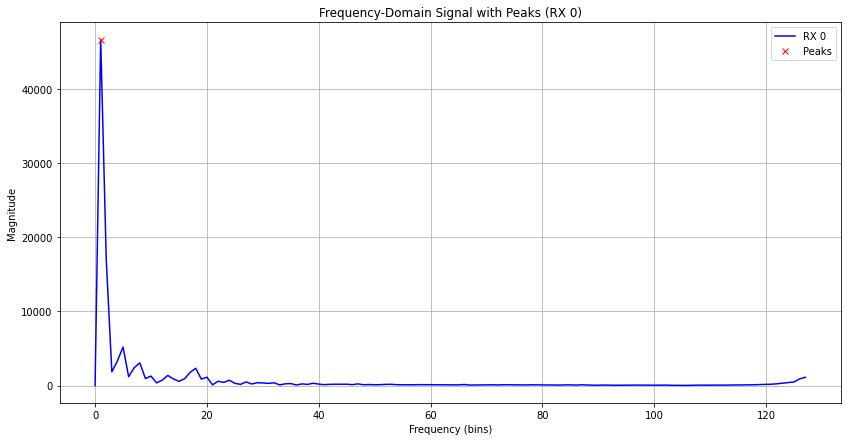

In [55]:
# scipy find peak on np.abs(first_chirp_ffts[0, :])

from scipy.signal import find_peaks

peaks, _ = find_peaks(np.abs(first_chirp_ffts[0, :N//2]), height=10000)

# plot
plt.figure(figsize=(14, 7))
plt.plot(np.abs(first_chirp_ffts[0, :N//2]), label='RX 0', color='blue')
plt.plot(peaks, np.abs(first_chirp_ffts[0, peaks]), "x", label='Peaks', color='red')
plt.title('Frequency-Domain Signal with Peaks (RX 0)')
plt.xlabel('Frequency (bins)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)

In [56]:
# print peaks found:
for peak in peaks:
    print(f"Peak at index {peak}, range: {peak * RESOLUTION:.2f} m, frequency: {peak * SAMPLE_RATE / SAMPLES_PER_CHIRP / 1e6:.2f} MHz")

Peak at index 1, range: 0.20 m, frequency: 0.04 MHz


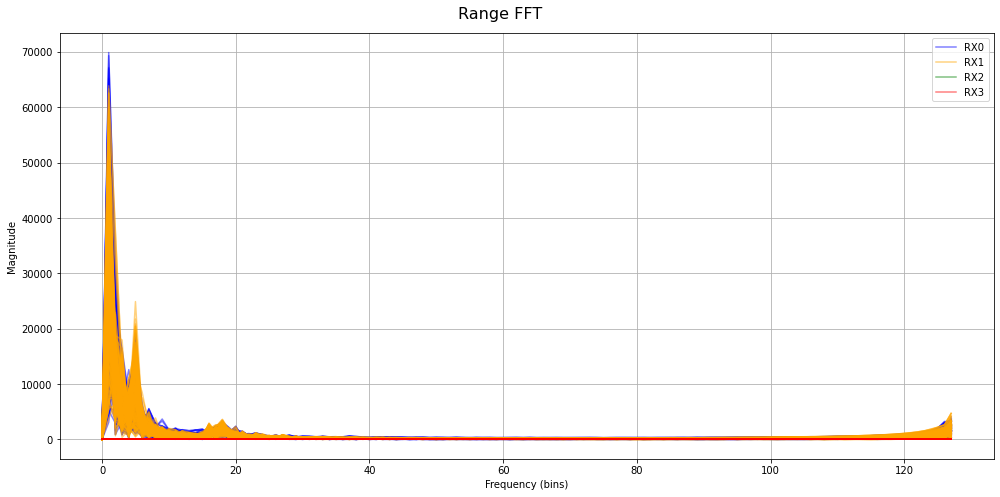

In [57]:
# Apply FFT along the sample (fast time) axis
range_ffts = fft(chirps[:, :, :] , axis=1)                   # shape (frames, samples)
N = range_ffts.shape[1]                                      # number of samples

# Plot the range FFT for the first 3 frames
plt.figure(figsize=(14, 7))
plt.suptitle('Range FFT', fontsize=16)
plt.xlabel('Frequency (bins)')
plt.ylabel('Magnitude')
color_map = ['blue', 'orange', 'green', 'red']
for rx in range(NUMRX):
    for frame in range(range_ffts.shape[0]):
        if frame == 0:
            plt.plot(np.abs(range_ffts[frame, :N//2, rx]), label=f'RX{rx}', color=color_map[rx], alpha=0.5)
        else:
            plt.plot(np.abs(range_ffts[frame, :N//2, rx]), color=color_map[rx], alpha=0.5)
plt.legend()
plt.grid(True)
plt.tight_layout()

(0.0, 2.0)

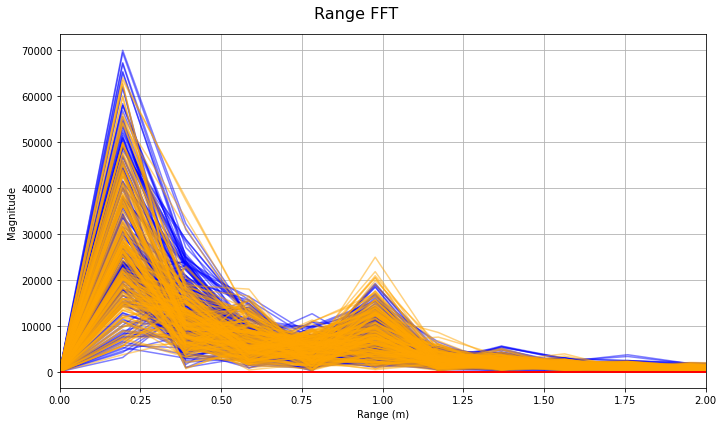

In [58]:
# convert freqs to meters
N = range_ffts.shape[1]  # number of samples
fft_freqs = fftfreq(N, 1 / (SAMPLE_RATE))  # Frequency bins
range_meters = fft_freqs[:N//2] * c / (2 * FREQ_SLOPE)

# Plot the range FFT for all frames
plt.figure(figsize=(10, 6))
plt.suptitle('Range FFT', fontsize=16)
color_map = ['blue', 'orange', 'green', 'red']
for rx in range(NUMRX):
    for frame in range(range_ffts.shape[0]):
        plt.plot(range_meters, np.abs(range_ffts[frame, :N//2, rx]), label=f'RX{rx} Frame {frame}', alpha=0.5, color=color_map[rx])
plt.xlabel('Range (m)')
plt.ylabel('Magnitude')
# plt.legend()
plt.grid(True)
plt.tight_layout()

# zoom into first 5 meters
plt.xlim(0, 2)

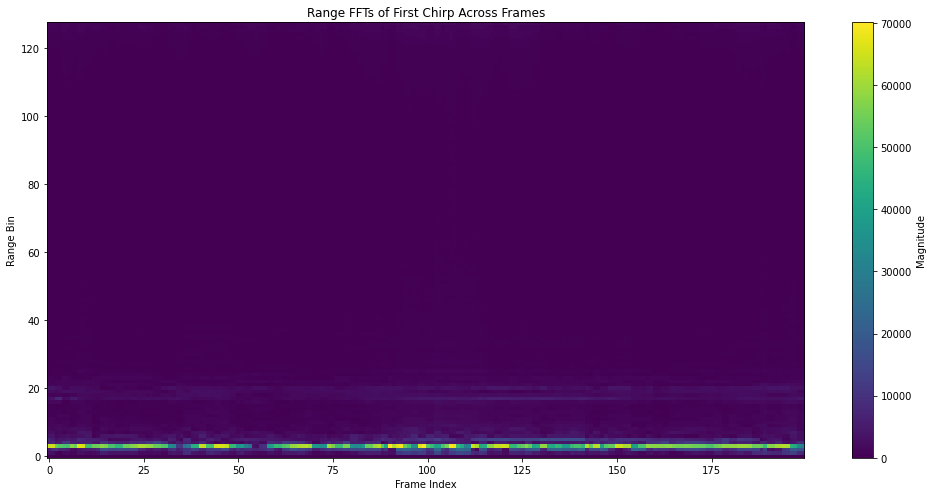

In [46]:
# range FFTs for all frames
plt.figure(figsize=(14, 7))
plt.imshow(np.abs(range_ffts[:, :N//2, 0]).T, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Magnitude')
plt.title("Range FFTs of First Chirp Across Frames")
plt.xlabel("Frame Index")
plt.ylabel("Range Bin")
plt.tight_layout()

In [15]:
# frame config
# NUM_FRAMES = 8
# NUM_CHIRP = 128                 # chirp loop count
# PERIODICITY = 40                # periodicity in ms
NUM_FRAMES = 100*2
NUM_CHIRP = 128                 # chirp loop count
PERIODICITY = 100               # periodicity in ms

# profile config
FREQUENCY = 77                  # start frequency
SAMPLES_PER_CHIRP = 256         # ADC number of samples
SAMPLE_RATE_KHZ = 10000         # digout sample rate in kHz
RAMP_END_TIME_US = 60           # us
ADC_START_TIME_US = 6           # us
FREQ_SLOPE_MHZ = 29.982         # frequency slope in MHz (/us)

# chan & adc config
NUMRX = 4

SAMPLE_RATE = SAMPLE_RATE_KHZ * 1e3             # digout sample rate in Hz
SWEEP_TIME = SAMPLES_PER_CHIRP / SAMPLE_RATE
FREQ_SLOPE = FREQ_SLOPE_MHZ * 1e12              # frequency slope in Hz (/s)

BANDWIDTH = FREQ_SLOPE * SWEEP_TIME             # bandwidth in Hz
RESOLUTION = c / (2 * BANDWIDTH)                # range resolution in m

print(f"Start frequency: {FREQUENCY} Hz")
print(f"Bandwidth: {BANDWIDTH} Hz")
print(f"Sweep time: {SWEEP_TIME} s")
print(f"Slope: {FREQ_SLOPE} Hz/s")
print(f"Range resolution: {RESOLUTION} m")
print(f"Sample rate: {SAMPLE_RATE} Hz")

adc_data = load_radar_file('./adc_data_Raw_0_box.bin', NUM_FRAMES, NUM_CHIRP, SAMPLES_PER_CHIRP, NUMRX)
print("ADC Data shape:", adc_data.shape)

Start frequency: 77 Hz
Bandwidth: 767539200.0 Hz
Sweep time: 2.56e-05 s
Slope: 29982000000000.0 Hz/s
Range resolution: 0.19542975785471284 m
Sample rate: 10000000.0 Hz
ADC Data shape: (200, 128, 256, 4)
